# Geographic Correlation to POI: air temperature (reanalysis) and precipitation (GPCC)

Calculate correlation between geographic points surrounding St. Louis, MO for chosen environmental variables. 

#### import packages

In [1]:
import env_methods as em 
import vis_methods as vm 
import time 
import numpy as np
import copy

#### initial parameters 

In [9]:
st_lou = [38.611389, - 90.203154] #lat/lon coords of a taco joint in st. lou 

lat_start = 60
lat_end = 0
lon_start = -180
lon_end =  -20

#lat_start = 50
#lat_end = 20
#lon_start = -110
#lon_end =  -80

gpcc_dir = r'D:\GPCC'
air_dir = r'D:\NOAA - just air'

#### import data

In [3]:
start_time = time.time()
pre_dic = em.get_data_gpcc(gpcc_dir, 1) #1 degree resolution, can't handle 0.25 deg res 
print("--- %s seconds for GPCC ---" % (time.time() - start_time))

--- 38.60114669799805 seconds for GPCC ---


In [4]:
start_time = time.time()
air_dic = em.get_data(air_dir, True, [0]) #1 degree resolution, can't handle 0.25 deg res 

air = air_dic['nc_vars']['air'][:,0,:,:]
#air = em.normalize_data(air, air_dic['time'])
air_dic['air'] = air_dic.pop('nc_vars')
air_dic['air'] = air
air_dic['lon'] = [x - 180 for x in air_dic['lon']]
print("--- %s seconds for air temp ---" % (time.time() - start_time))

acquring data from air.mon.mean.nc
--- 27.99227213859558 seconds for air temp ---


In [5]:
def compress2annual(dp, var):
    num_years = dp['time'][-1].year - dp['time'][0].year + 1 
    new_data = np.empty((num_years, dp[var].shape[1], dp[var].shape[2]))
    time_new = np.arange(dp['time'][0].year, dp['time'][-1].year + 1).tolist()

    for y in time_new: 
        inds = em.get_year_indices(dp['time'], y)
        arr = np.mean(dp[var][inds, :, : ], axis = 0)
        
        new_data[time_new.index(y), :, :] = arr
    
    dp['time'] = time_new
    dp[var] = new_data
    
    return dp 

air_dic = compress2annual(copy.deepcopy(air_dic), 'air')
pre_dic = compress2annual(copy.deepcopy(pre_dic), 'precip')

#### geospatial correlation method

In [6]:
#method to generate a correlation grid 
#assume grid = time x lat x lon 
def corr_grid(array, poi):
    corr = np.empty([array.shape[1], array.shape[2]])
    comp = array[:, poi[0], poi[1]] #time series at poi 
    for i in range(array.shape[1]):
        for j in range(array.shape[2]):
            comp0 = array[:, i, j]
            corr[i, j] = np.corrcoef(comp, comp0)[0,1]
    return corr

#### run correlation on each dictionary 

In [7]:
start_time = time.time()
dics = [pre_dic, air_dic]
name = ['precip', 'air']
c = []
for i in range(len(dics)):
    d = dics[i]
    poi = [em.find_closest_val(st_lou[0], d['lat']), em.find_closest_val(st_lou[1], d['lon'])]
    c.append(corr_grid(d[name[i]], poi))
print("--- %s seconds for correlation  ---" % (time.time() - start_time))

--- 9.442136526107788 seconds for correlation  ---


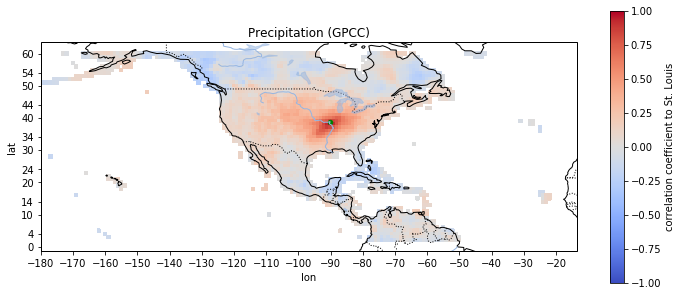

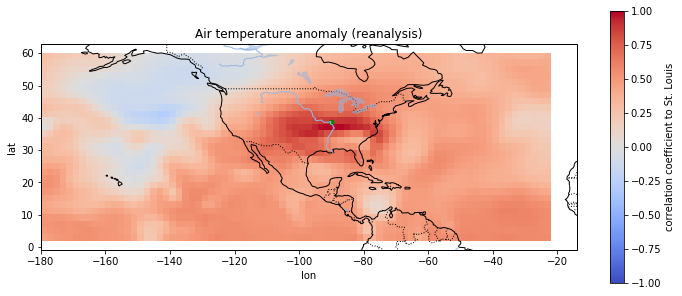

In [10]:
import matplotlib.pyplot as plt 
import cartopy 
import cartopy.crs as ccrs 
def plot_corr(dic, array, title, lat_start, lat_end, lon_start, lon_end):
    lat = dic['lat']
    lon = dic['lon']
    lat1 = em.find_closest_val(lat_start, lat)
    lat2 = em.find_closest_val(lat_end, lat)
    lon1 = em.find_closest_val(lon_start, lon)
    lon2 = em.find_closest_val(lon_end, lon)

    fig = plt.figure(figsize = (12, 5))
    fig.patch.set_facecolor('white')
    ax = plt.subplot(projection = ccrs.PlateCarree())

    ax.coastlines()
    plt.title(title)
    plt.xlabel('lon')
    plt.ylabel('lat')
    ax.set_xticks(np.round(np.asarray(lon[::10])))
    ax.set_yticks(np.round(np.asarray(lat[::5])))
    mesh = plt.pcolormesh(lon[lon1:lon2], lat[lat1:lat2], array[lat1:lat2,lon1:lon2], cmap = 'coolwarm', vmax = 1, vmin = -1)
    cbar = plt.colorbar(mesh)
    plt.scatter(st_lou[1], st_lou[0], color = 'green', s = 20)
    cbar.set_label('correlation coefficient to St. Louis')
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)

plot_corr(pre_dic, c[0], 'Precipitation (GPCC)', lat_start, lat_end, lon_start, lon_end)
plot_corr(air_dic, c[1], 'Air temperature anomaly (reanalysis)', lat_start, lat_end,lon_start, lon_end)